In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
#from astroquery import TAP
import healpy as hp
from astroquery.utils.tap.core import TapPlus
from astroquery.xmatch import XMatch
import time
import astropy.units as u

In [3]:
# Set up astroquery
delve = TapPlus(url='https://datalab.noirlab.edu/tap')


In [4]:
job = delve.launch_job('SELECT TOP 1000 * FROM delve_dr2.objects')


In [5]:
r = job.get_results()

# Test a healpix

In [6]:
# Constants for Nside 2048
Nside = 2048
npix = hp.nside2npix(Nside)

# Generate the array of HEALPix pixel indices
healpix_indices = np.arange(npix)

# Get the angular coordinates of the center of each pixel
l, b = hp.pix2ang(Nside, healpix_indices, lonlat= True)

# Filter indices based on galactic latitude
southern_hemisphere_indices = healpix_indices[b < -20]

# Now, `southern_hemisphere_indices` contains the HEALPix indices in the southern galactic hemisphere


In [7]:


# Constants for Nside ring 256
Nside = 256
npix = hp.nside2npix(Nside)

# Generate the array of HEALPix pixel indices
healpix_indices = np.arange(npix)

# Get the angular coordinates of the center of each pixel
l, b = hp.pix2ang(Nside, healpix_indices, lonlat= True)

# Filter indices based on galactic latitude
southern_hemisphere_indices = healpix_indices[b < -20]

# Now, `southern_hemisphere_indices` contains the HEALPix indices in the southern galactic hemisphere

0.0 180.0 -180.0 180.0


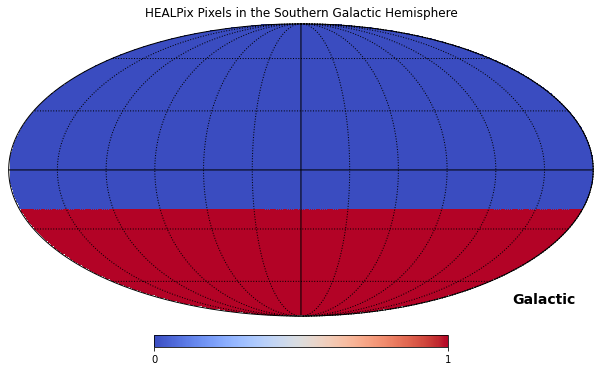

In [8]:
# Prepare a map where only the selected pixels are highlighted
hpx_map = np.zeros(npix, dtype=np.float64)
hpx_map[southern_hemisphere_indices] = 1  # Set selected pixels to 1
hp.mollview(hpx_map, title="HEALPix Pixels in the Southern Galactic Hemisphere", coord=['G'], cmap='coolwarm', min=0, max=1)
hp.graticule()


In [9]:
def query_delve_healpix(healpix):
    query = f"""SELECT o.*
            FROM delve_dr2.objects AS o
            WHERE o.extended_class_g = 0
            AND o.hpx2048 = {healpix} 
            AND o.extended_class_i = 0
            AND o.extended_class_z = 0
            AND (o.mag_psf_g - o.mag_psf_i) > 1.2
            AND (o.mag_psf_g - o.mag_psf_i) < 2.6
            AND o.flags_g = 0
            AND o.flags_i = 0
            AND o.flags_r = 0
            AND o.flags_z = 0"""
    
    # Run query using the TAP service 
    job = delve.launch_job(query= query)

    return job.get_results()

def query_delve_256(healpix):
    query = f"""SELECT o.*
            FROM delve_dr2.objects AS o
            WHERE o.extended_class_g = 0
            AND o.ring256 = {healpix} 
            AND o.extended_class_i = 0
            AND o.extended_class_z = 0
            AND (o.mag_psf_g - o.mag_psf_i) > 1.2
            AND (o.mag_psf_g - o.mag_psf_i) < 2.6
            AND o.flags_g = 0
            AND o.flags_i = 0
            AND o.flags_r = 0
            AND o.flags_z = 0"""
    
    # Run query using the TAP service 
    job = delve.launch_job(query= query)

    return job.get_results()

In [20]:
delve_data = query_delve_256(southern_hemisphere_indices[0])

In [21]:
delve_data

a_image_g,a_image_i,a_image_r,a_image_z,b_image_g,b_image_i,b_image_r,b_image_z,ccdnum_g,ccdnum_i,ccdnum_r,ccdnum_z,class_star_g,class_star_i,class_star_r,class_star_z,dec,ebv,expnum_g,expnum_i,expnum_r,expnum_z,exptime_g,exptime_i,exptime_r,exptime_z,extended_class_g,extended_class_i,extended_class_r,extended_class_z,extinction_g,extinction_i,extinction_r,extinction_z,flags_g,flags_i,flags_r,flags_z,hpx2048,htm9,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,mag_psf_g,mag_psf_i,mag_psf_r,mag_psf_z,magerr_auto_g,magerr_auto_i,magerr_auto_r,magerr_auto_z,magerr_psf_g,magerr_psf_i,magerr_psf_r,magerr_psf_z,nepochs_g,nepochs_i,nepochs_r,nepochs_z,nest4096,quick_object_id,ra,random_id,ring256,spread_model_g,spread_model_i,spread_model_r,spread_model_z,spreaderr_model_g,spreaderr_model_i,spreaderr_model_r,spreaderr_model_z,t_eff_g,t_eff_i,t_eff_r,t_eff_z,theta_image_g,theta_image_i,theta_image_r,theta_image_z,wavg_flags_g,wavg_flags_i,wavg_flags_r,wavg_flags_z,wavg_mag_auto_g,wavg_mag_auto_i,wavg_mag_auto_r,wavg_mag_auto_z,wavg_mag_psf_g,wavg_mag_psf_i,wavg_mag_psf_r,wavg_mag_psf_z,wavg_magerr_auto_g,wavg_magerr_auto_i,wavg_magerr_auto_r,wavg_magerr_auto_z,wavg_magerr_psf_g,wavg_magerr_psf_i,wavg_magerr_psf_r,wavg_magerr_psf_z,wavg_magrms_auto_g,wavg_magrms_auto_i,wavg_magrms_auto_r,wavg_magrms_auto_z,wavg_magrms_psf_g,wavg_magrms_psf_i,wavg_magrms_psf_r,wavg_magrms_psf_z,wavg_spread_model_g,wavg_spread_model_i,wavg_spread_model_r,wavg_spread_model_z,wavg_spreaderr_model_g,wavg_spreaderr_model_i,wavg_spreaderr_model_r,wavg_spreaderr_model_z,wavg_spreadrms_model_g,wavg_spreadrms_model_i,wavg_spreadrms_model_r,wavg_spreadrms_model_z,mjd_obs,elon,elat,glon,glat
pix,pix,pix,pix,pix,pix,pix,pix,,,,,,,,,deg,mag,,,,,s,s,s,s,,,,,mag,mag,mag,mag,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,deg,,,,,,,,,,,,,,,deg,deg,deg,deg,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,days,deg,deg,deg,deg
float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float32,float32,float64,float32,int32,int32,int32,int32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,int16,int16,int16,int64,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int32,int64,float64,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64


In [89]:
delve_data.write('/Users/mncavieres/Documents/2024-1/Delve/Data/DELVE/test_healpix.dat', format = 'ascii')

In [91]:
delve_data = Table.read('/Users/mncavieres/Documents/2024-1/Delve/Data/DELVE/test_healpix.dat', format = 'ascii')

In [13]:
# xmatch with VHS data
xmatch_result = XMatch.query(cat1=delve_data, cat2='vizier:II/367/vhs_dr5', max_distance=1 * u.arcsec, colRA1='ra', colDec1='dec', colRA2='RA2000', colDec2= 'DEC2000')

In [14]:
xmatch_result

angDist,a_image_g,a_image_i,a_image_r,a_image_z,b_image_g,b_image_i,b_image_r,b_image_z,ccdnum_g,ccdnum_i,ccdnum_r,ccdnum_z,class_star_g,class_star_i,class_star_r,class_star_z,dec,ebv,expnum_g,expnum_i,expnum_r,expnum_z,exptime_g,exptime_i,exptime_r,exptime_z,extended_class_g,extended_class_i,extended_class_r,extended_class_z,extinction_g,extinction_i,extinction_r,extinction_z,flags_g,flags_i,flags_r,flags_z,hpx2048,htm9,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,mag_psf_g,mag_psf_i,mag_psf_r,mag_psf_z,magerr_auto_g,magerr_auto_i,magerr_auto_r,magerr_auto_z,magerr_psf_g,magerr_psf_i,magerr_psf_r,magerr_psf_z,nepochs_g,nepochs_i,nepochs_r,nepochs_z,nest4096,quick_object_id,ra,random_id,ring256,spread_model_g,spread_model_i,spread_model_r,spread_model_z,spreaderr_model_g,spreaderr_model_i,spreaderr_model_r,spreaderr_model_z,t_eff_g,t_eff_i,t_eff_r,t_eff_z,theta_image_g,theta_image_i,theta_image_r,theta_image_z,wavg_flags_g,wavg_flags_i,wavg_flags_r,wavg_flags_z,wavg_mag_auto_g,wavg_mag_auto_i,wavg_mag_auto_r,wavg_mag_auto_z,wavg_mag_psf_g,wavg_mag_psf_i,wavg_mag_psf_r,wavg_mag_psf_z,wavg_magerr_auto_g,wavg_magerr_auto_i,wavg_magerr_auto_r,wavg_magerr_auto_z,wavg_magerr_psf_g,wavg_magerr_psf_i,wavg_magerr_psf_r,wavg_magerr_psf_z,wavg_magrms_auto_g,wavg_magrms_auto_i,wavg_magrms_auto_r,wavg_magrms_auto_z,wavg_magrms_psf_g,wavg_magrms_psf_i,wavg_magrms_psf_r,wavg_magrms_psf_z,wavg_spread_model_g,wavg_spread_model_i,wavg_spread_model_r,wavg_spread_model_z,wavg_spreaderr_model_g,wavg_spreaderr_model_i,wavg_spreaderr_model_r,wavg_spreaderr_model_z,wavg_spreadrms_model_g,wavg_spreadrms_model_i,wavg_spreadrms_model_r,wavg_spreadrms_model_z,mjd_obs,elon,elat,glon,glat,SrcID,RAJ2000,DEJ2000,FrameID,PriOrSec,Y-Jpnt,J-Hpnt,H-Kspnt,J-Kspnt,Y-Jext,J-Hext,H-Ksext,J-Ksext,Mclass,Ypmag,e_Ypmag,Yap3,e_Yap3,Yapc3,Yavgap3,Yperrbits,Jpmag,e_Jpmag,Jap3,e_Jap3,Japc3,Javgap3,Jperrbits,Hpmag,e_Hpmag,Hap3,e_Hap3,Hapc3,Havgap3,Hperrbits,Kspmag,e_Kspmag,Ksap3,e_Ksap3,Ksapc3,Ksavgap3,Ksperrbits,prim
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,int64,int64,int64,float64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64
0.230234,1.8274799585342407,1.8464800119400024,1.9617199897766113,2.0764400959014893,1.7717900276184082,1.7513600587844849,1.8401999473571777,1.7955800294876099,29,27,27,11,0.9763780236244202,0.9838020205497742,0.9811000227928162,0.9763789772987366,-20.15932488122887,0.022460000589489937,798651,706822,706821,395534,90.0,90.0,90.0,90.0,0,0,0,0,0.07155799865722656,0.03523999825119972,0.04806499928236008,0.02686299942433834,0,0,0,0,37331360,2318290,22.327682495117188,20.667377471923828,21.110570907592773,20.341882705688477,22.301742553710938,20.58180046081543,21.064266204833984,20.343271255493164,0.060502998530864716,0.02806599996984005,0.025165999308228493,0.050071001052856445,0.031863998621702194,0.014504999853670597,0.01468999963253736

In [69]:
15.2*len(southern_hemisphere_indices)/(60*60*24)  

45.48740740740741

In [18]:

output_delve =  '/Users/mncavieres/Documents/2024-1/Delve/Data/test/delve' #'/fast_scratch3/mncavieres/DELVE'
output_matched =  '/Users/mncavieres/Documents/2024-1/Delve/Data/test/delve/vhs_delve' #'/fast_scratch3/mncavieres/delveXvhs'

print('Running query for NSIDE 256')
# Constants for Nside ring 256
Nside = 256
npix = hp.nside2npix(Nside)

# Generate the array of HEALPix pixel indices
healpix_indices = np.arange(npix)

# Get the angular coordinates of the center of each pixel
l, b = hp.pix2ang(Nside, healpix_indices, lonlat= True)

# Filter indices based on galactic latitude
southern_hemisphere_indices = healpix_indices[b < -20]

# Now, `southern_hemisphere_indices` contains the HEALPix indices in the southern galactic hemisphere



# query data
delve_data = query_delve_256(southern_hemisphere_indices[1])

# save data
#delve_data.write(os.path.join(output_delve, f'delve_{healpix}.dat'), format = 'ascii', overwrite= True)

# xmatch with VHS data
xmatch_result = XMatch.query(cat1=delve_data, cat2='vizier:II/367/vhs_dr5', max_distance=1 * u.arcsec, colRA1='ra', colDec1='dec', colRA2='RA2000', colDec2= 'DEC2000')

# save the xmatch result
#xmatch_result.write(os.path.join(output_matched,  f'delve_x_vhs_{healpix}.dat'), format = 'ascii', overwrite= True)


Running query for NSIDE 256


HTTPError: 400 Client Error: Mauvaise Requête for url: http://cdsxmatch.u-strasbg.fr/xmatch/api/v1/sync

In [19]:
delve_data

a_image_g,a_image_i,a_image_r,a_image_z,b_image_g,b_image_i,b_image_r,b_image_z,ccdnum_g,ccdnum_i,ccdnum_r,ccdnum_z,class_star_g,class_star_i,class_star_r,class_star_z,dec,ebv,expnum_g,expnum_i,expnum_r,expnum_z,exptime_g,exptime_i,exptime_r,exptime_z,extended_class_g,extended_class_i,extended_class_r,extended_class_z,extinction_g,extinction_i,extinction_r,extinction_z,flags_g,flags_i,flags_r,flags_z,hpx2048,htm9,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,mag_psf_g,mag_psf_i,mag_psf_r,mag_psf_z,magerr_auto_g,magerr_auto_i,magerr_auto_r,magerr_auto_z,magerr_psf_g,magerr_psf_i,magerr_psf_r,magerr_psf_z,nepochs_g,nepochs_i,nepochs_r,nepochs_z,nest4096,quick_object_id,ra,random_id,ring256,spread_model_g,spread_model_i,spread_model_r,spread_model_z,spreaderr_model_g,spreaderr_model_i,spreaderr_model_r,spreaderr_model_z,t_eff_g,t_eff_i,t_eff_r,t_eff_z,theta_image_g,theta_image_i,theta_image_r,theta_image_z,wavg_flags_g,wavg_flags_i,wavg_flags_r,wavg_flags_z,wavg_mag_auto_g,wavg_mag_auto_i,wavg_mag_auto_r,wavg_mag_auto_z,wavg_mag_psf_g,wavg_mag_psf_i,wavg_mag_psf_r,wavg_mag_psf_z,wavg_magerr_auto_g,wavg_magerr_auto_i,wavg_magerr_auto_r,wavg_magerr_auto_z,wavg_magerr_psf_g,wavg_magerr_psf_i,wavg_magerr_psf_r,wavg_magerr_psf_z,wavg_magrms_auto_g,wavg_magrms_auto_i,wavg_magrms_auto_r,wavg_magrms_auto_z,wavg_magrms_psf_g,wavg_magrms_psf_i,wavg_magrms_psf_r,wavg_magrms_psf_z,wavg_spread_model_g,wavg_spread_model_i,wavg_spread_model_r,wavg_spread_model_z,wavg_spreaderr_model_g,wavg_spreaderr_model_i,wavg_spreaderr_model_r,wavg_spreaderr_model_z,wavg_spreadrms_model_g,wavg_spreadrms_model_i,wavg_spreadrms_model_r,wavg_spreadrms_model_z,mjd_obs,elon,elat,glon,glat
pix,pix,pix,pix,pix,pix,pix,pix,,,,,,,,,deg,mag,,,,,s,s,s,s,,,,,mag,mag,mag,mag,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,deg,,,,,,,,,,,,,,,deg,deg,deg,deg,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,days,deg,deg,deg,deg
float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float32,float32,float64,float32,int32,int32,int32,int32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,int16,int16,int16,int64,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int32,int64,float64,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64


# Plotting for each iteration

In [83]:
hpx_map[:100000] = 5

0.0 180.0 -180.0 180.0


<Figure size 432x288 with 0 Axes>

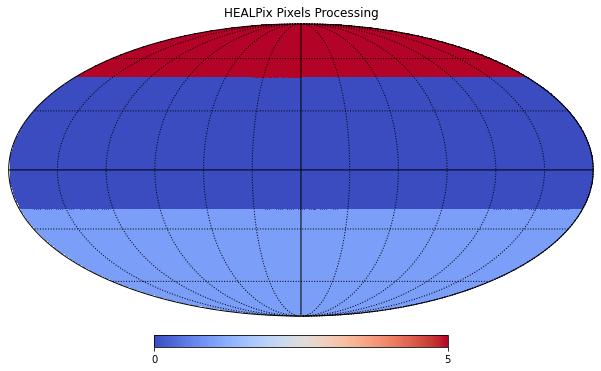

0.0 180.0 -180.0 180.0


<Figure size 432x288 with 0 Axes>

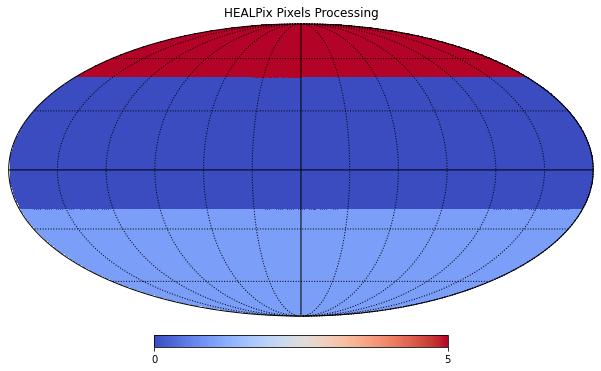

0.0 180.0 -180.0 180.0


<Figure size 432x288 with 0 Axes>

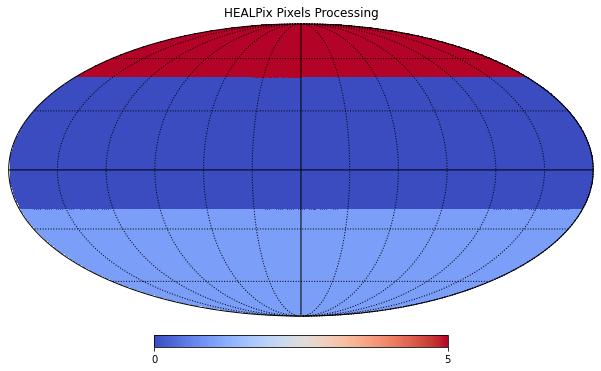

0.0 180.0 -180.0 180.0


<Figure size 432x288 with 0 Axes>

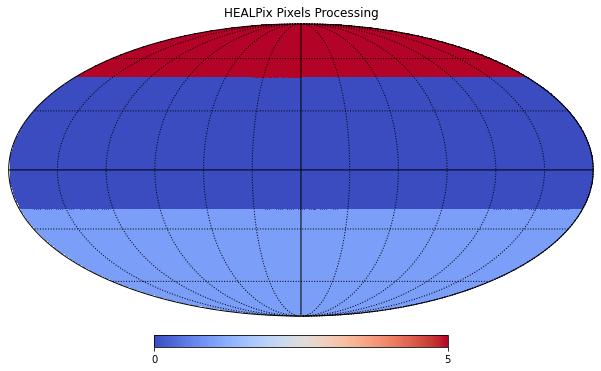

KeyboardInterrupt: 

In [84]:

# Iterate over southern hemisphere indices
for i in southern_hemisphere_indices[100000:]:
    # Update the map for the currently processed pixel
    hpx_map[i] = 5  # Mark the current pixel distinctively
    
    # Clear the current figure to avoid overlaying multiple plots
    plt.clf()  # Use plt.clf() to clear the figure
    
    # Plotting
    hp.mollview(hpx_map, title="HEALPix Pixels Processing", coord=['G'], cmap='coolwarm', min=0, max=5, notext=True)
    hp.graticule()
    
    # Display the plot
    plt.show(block=False)
    plt.pause(0.1)  # Use plt.pause() for a short delay and to update the plot in some environments
    
    # Reset the map value after displaying, if you only want to highlight the sequence of processing
    #hpx_map[i] = 1  # Reset the processed pixel to its original state if needed

    # Wait 5 seconds before the next iteration
    time.sleep(5)

# Optionally, clear the plot after the loop completes to clean up the last displayed figure
plt.clf()